### Examples of Stochastic Processes from Real World

Next, we apply the theory discussed and presented in previous sessions to some real-world problems. Financial markets represent one of the areas where stochastic processes are sucessfully applied. In particular, they are used to analyse and predict time-evolution of stock-prices. 

##### Logarithmic change in price
As we are mainly interested in how given stock/index performs in terms of returns (rather than just prize, which is of limited use), we define the logarithmic change $G_{\tau}(t)$ as:
$$G_{\tau}(t) = \log{P(t+\tau)} - \log{P(t)}.$$

This may appear cumbersome at the first sight, but notice that if the relative change of stock price is small ($\Delta_\tau P= P(t+\tau) - P(t) \ll P(t)$), this is simply an approximation of relative change:

$$G_\tau(t) = \ln{\left[\frac{P(t+\tau)}{P(t)}\right]} = \ln{\left[\frac{P(t) + \Delta_\tau P(t)}{P(t)}\right]} = \ln{\left[1 + \frac{\Delta_\tau P(t)}{P(t)}\right]},$$
$$\ln{\left( 1 + x\right)} = x - \frac{x^2}{2} + \cdots \hspace{20mm} (\mathrm{for}\, \lvert x\rvert < 1)$$
$$G_\tau(t) \simeq \frac{\Delta_\tau P(t)}{P(t)} = \frac{P(t+\tau) - P(t)}{P(t)}.$$

In [17]:
import pandas as pd # import pandas library as pd
from datetime import datetime
from pandas_datareader import data as pdr
from pandas_datareader import wb   as pwb
import numpy as np  # import numpy library as np
import math         # use mathematical functions defined by the C standard
import matplotlib.pyplot as plt # import pyplot library as plt 
import time
plt.style.use('ggplot') # use "ggplot" style for graphs
pltparams = {'legend.fontsize': 16, 'axes.labelsize': 16, 'axes.titlesize': 16,
             'xtick.labelsize': 12, 'ytick.labelsize':12, 'figure.figsize': (7, 7),}
plt.rcParams.update(pltparams)
% matplotlib inline

Define helper functions:

In [75]:
def logreturn(Pt, tau = 1):
    # Logarithmic retruns of price time series:
    logret = np.log(Pt[tau:]) - np.log(Pt[0:-tau])
    return logret
def normalize(data):
    # Normalize data by std to unit variance
    # <(x - <x>)^2> = 1
    return data/np.sqrt(np.var(data))
def pdf_estimate(data, bins = 50):
    hist, edges = np.histogram(data[~np.isnan(data)], bins = bins, density = True)
    centers  = edges[:-1] + np.diff(edges)/2.0 # get bar centers
    nonzero = hist > 0.0
    return hist[nonzero], centers[nonzero]

Import data:

In [ ]:
yrs_retro = 30
key = "26d15933a5005fca233802351f2ffeadc343e10f"
end_time = datetime.now()
start_time = datetime(end_time.year - yrs_retro, end_time.month, end_time.day)
# Read from yahoo finance
data = list()
tickers = ["7203", "8031", "8058", "AAPL", "MSFT", "HPQ", "^N225", "^GSPC"]
rep = np.ones(len(tickers), dtype = np.int).tolist()
while any(rep):
    for ticker in [t for j,t in enumerate(tickers) if rep[j]==True]:
        i = tickers.index(ticker)
        try:
            data[i] = pdr.get_data_yahoo(ticker, start_time, end_time)
            rep[i] = False
        except:
            print("Data for {} unacessible".format(ticker))
        time.sleep(1)

Data for 7203 unacessible
Data for 8031 unacessible
Data for 8058 unacessible
Data for AAPL unacessible
Data for MSFT unacessible
Data for HPQ unacessible
Data for ^N225 unacessible
Data for ^GSPC unacessible
Data for 7203 unacessible
Data for 8031 unacessible
Data for 8058 unacessible
Data for AAPL unacessible
Data for MSFT unacessible
Data for HPQ unacessible
Data for ^N225 unacessible
Data for ^GSPC unacessible
Data for 7203 unacessible
Data for 8031 unacessible
Data for 8058 unacessible
Data for AAPL unacessible
Data for MSFT unacessible
Data for HPQ unacessible
Data for ^N225 unacessible


Unfortunately, the yahoo finance has been discontinued. We therefore simulate some data from a stochastic process. We use code developed in a blog post, <a href="http://www.stuartreid.co.za/random-walks-down-wall-street-stochastic-processes-in-python/">Random Walks Down Wall Street, Stochastic Processes in Python</a>.

Import:

In [2]:
import math
import numpy
import random
import decimal
import scipy.linalg
import numpy.random as nrand
import matplotlib.pyplot as plt
plt.style.use('ggplot') # use "ggplot" style for graphs
pltparams = {'legend.fontsize': 16, 'axes.labelsize': 16, 'axes.titlesize': 16,
             'xtick.labelsize': 12, 'ytick.labelsize':12, 'figure.figsize': (7, 7),}
plt.rcParams.update(pltparams)
% matplotlib inline

Model Parameters Class:

In [3]:
class ModelParameters:
    """
    Encapsulates model parameters
    """

    def __init__(self,
                 all_s0, all_time, all_delta, all_sigma, gbm_mu,
                 jumps_lamda=0.0, jumps_sigma=0.0, jumps_mu=0.0,
                 cir_a=0.0, cir_mu=0.0, all_r0=0.0, cir_rho=0.0,
                 ou_a=0.0, ou_mu=0.0,
                 heston_a=0.0, heston_mu=0.0, heston_vol0=0.0):
        # This is the starting asset value
        self.all_s0 = all_s0
        # This is the amount of time to simulate for
        self.all_time = all_time
        # This is the delta, the rate of time e.g. 1/252 = daily, 1/12 = monthly
        self.all_delta = all_delta
        # This is the volatility of the stochastic processes
        self.all_sigma = all_sigma
        # This is the annual drift factor for geometric brownian motion
        self.gbm_mu = gbm_mu
        # This is the probability of a jump happening at each point in time
        self.lamda = jumps_lamda
        # This is the volatility of the jump size
        self.jumps_sigma = jumps_sigma
        # This is the average jump size
        self.jumps_mu = jumps_mu
        # This is the rate of mean reversion for Cox Ingersoll Ross
        self.cir_a = cir_a
        # This is the long run average interest rate for Cox Ingersoll Ross
        self.cir_mu = cir_mu
        # This is the starting interest rate value
        self.all_r0 = all_r0
        # This is the correlation between the wiener processes of the Heston model
        self.cir_rho = cir_rho
        # This is the rate of mean reversion for Ornstein Uhlenbeck
        self.ou_a = ou_a
        # This is the long run average interest rate for Ornstein Uhlenbeck
        self.ou_mu = ou_mu
        # This is the rate of mean reversion for volatility in the Heston model
        self.heston_a = heston_a
        # This is the long run average volatility for the Heston model
        self.heston_mu = heston_mu
        # This is the starting volatility value for the Heston model
        self.heston_vol0 = heston_vol0

In [76]:
mp = ModelParameters(all_s0=1000,
                     all_r0=0.5,
                     all_time=8000,
                     all_delta=0.00396825396,
                     all_sigma=0.125,
                     gbm_mu=0.058,
                     jumps_lamda=0.00125,
                     jumps_sigma=0.001,
                     jumps_mu=-0.2,
                     cir_a=3.0,
                     cir_mu=0.5,
                     cir_rho=0.5,
                     ou_a=3.0,
                     ou_mu=0.5,
                     heston_a=0.25,
                     heston_mu=0.35,
                     heston_vol0=0.06125)

paths = 5

Helper functions definition:

In [5]:
def plot_stochastic_processes(processes, title):
    """
    This method plots a list of stochastic processes with a specified title
    :return: plots the graph of the two
    """
    fig, ax = plt.subplots(1)
    fig.suptitle(title, fontsize=16)
    ax.set_xlabel('Time, t')
    ax.set_ylabel('Simulated Asset Price')
    x_axis = numpy.arange(0, len(processes[0]), 1)
    for i in range(len(processes)):
        plt.plot(x_axis, processes[i])
    plt.show()

## <a href="http://en.wikipedia.org/wiki/Heston_model">The Heston Stochastic Volatility Model</a>

The original Geometric Brownian Motion stochastic process assumes that volatility over time is constant. In esence it is a Brownian motion with drift and volatility components. Its SDE (stochastic differential equation) is:

$$dS_t = \mu S_t dt + \sigma d S_t W_t$$

where $dS_t$ is the change in the asset price, $S$, at time $t$; $\mu$ is the percentage drift expected per annum, $dt$, represents time (1/252 is used for daily changes), $\sigma$ is the daily volatility expected in the asset prices, and $W_t$ is a Wiener process a.k.a Brownian Motion.

In the early 1990's Steven Heston relaxed this assumption and extended the Geometric Brownian Motion model to include stochastic volatility. The resulting model is called the Heston model. In the Heston model volatility over time evolves over time according to the Cox Ingersoll Ross stochastic process. As such the model makes use to two Wiener processes, one for the Cox Ingersoll Ross process and another for the Geometric Brownian Motion process which uses the Cox Ingersoll Ross process as volatility. These two Wiener processes are correlated and can be constructed using a Cholesky Decomposition. The stochastic differential equation for the Heston model is given as,

$$dS_t = \mu S_t dt + \sqrt{v_t}S_t d W^S_t$$
$$dv_t = a(b-v_t)dt + \sigma\sqrt{v_t} d W^v_t$$

where $\mu$ is the drift of the asset, $S^S$ and $W^v$ are two correlated Wiener processes where the correlation is given by $\rho$, $a$ is the rate of mean-reversion of the Cox Ingersoll Ross process, $b$ is the mean value over time (in this case the mean volatility over time), and $\sigma$ is the volatility of the Cox Ingersoll Ross process. The term, $a(b−vt)$ is also called the drift factor.

Correlated Wiener Process:

In [6]:
def heston_construct_correlated_path(param, brownian_motion_one):
    """
    This method is a simplified version of the Cholesky decomposition method for just two assets. It does not make use
    of matrix algebra and is therefore quite easy to implement.
    :param param: model parameters object
    :return: a correlated brownian motion path
    """
    # We do not multiply by sigma here, we do that in the Heston model
    sqrt_delta = math.sqrt(param.all_delta)
    # Construct a path correlated to the first path
    brownian_motion_two = []
    for i in range(param.all_time - 1):
        term_one = param.cir_rho * brownian_motion_one[i]
        term_two = math.sqrt(1 - math.pow(param.cir_rho, 2.0)) * random.normalvariate(0, sqrt_delta)
        brownian_motion_two.append(term_one + term_two)
    return numpy.array(brownian_motion_one), numpy.array(brownian_motion_two)

def get_correlated_geometric_brownian_motions(param, correlation_matrix, n):
    """
    This method can construct a basket of correlated asset paths using the Cholesky decomposition method
    :param param: model parameters object
    :param correlation_matrix: nxn correlation matrix
    :param n: the number of assets i.e. the number of paths to return
    :return: n correlated log return geometric brownian motion processes
    """
    assert isinstance(param, ModelParameters)
    decomposition = scipy.linalg.cholesky(correlation_matrix, lower=False)
    uncorrelated_paths = []
    sqrt_delta_sigma = math.sqrt(param.all_delta) * param.all_sigma
    # Construct uncorrelated paths to convert into correlated paths
    for i in range(param.all_time):
        uncorrelated_random_numbers = []
        for j in range(n):
            uncorrelated_random_numbers.append(random.normalvariate(0, sqrt_delta_sigma))
        uncorrelated_paths.append(numpy.array(uncorrelated_random_numbers))
    uncorrelated_matrix = numpy.matrix(uncorrelated_paths)
    correlated_matrix = uncorrelated_matrix * decomposition # HERE WE CREATE CORRELATED RVs!!
    assert isinstance(correlated_matrix, numpy.matrix)
    # The rest of this method just extracts paths from the matrix
    extracted_paths = []
    for i in range(1, n + 1):
        extracted_paths.append([])
    for j in range(0, len(correlated_matrix)*n - n, n):
        for i in range(n):
            extracted_paths[i].append(correlated_matrix.item(j + i))
    return extracted_paths

Construct volatility path:

In [7]:
def cox_ingersoll_ross_heston(param):
    """
    This method returns the rate levels of a mean-reverting cox ingersoll ross process. It is used to model interest
    rates as well as stochastic volatility in the Heston model. Because the returns between the underlying and the
    stochastic volatility should be correlated we pass a correlated Brownian motion process into the method from which
    the interest rate levels are constructed. The other correlated process is used in the Heston model
    :param param: the model parameters objects
    :return: the interest rate levels for the CIR process
    """
    # We don't multiply by sigma here because we do that in heston
    sqrt_delta_sigma = math.sqrt(param.all_delta) * param.all_sigma
    brownian_motion_volatility = nrand.normal(loc=0, scale=sqrt_delta_sigma, size=param.all_time)
    a, mu, zero = param.heston_a, param.heston_mu, param.heston_vol0
    volatilities = [zero]
    for i in range(1, param.all_time):
        drift = a * (mu - volatilities[i-1]) * param.all_delta
        randomness = math.sqrt(max(volatilities[i - 1], 0.05)) * brownian_motion_volatility[i - 1]
        volatilities.append(max(volatilities[i - 1], 0.05) + drift + randomness)
    return numpy.array(brownian_motion_volatility), numpy.array(volatilities)

Construct Asset Price levels:

In [8]:
def heston_model_levels(param):
    """
    NOTE - this method is dodgy! Need to debug!
    The Heston model is the geometric brownian motion model with stochastic volatility. This stochastic volatility is
    given by the cox ingersoll ross process. Step one on this method is to construct two correlated GBM processes. One
    is used for the underlying asset prices and the other is used for the stochastic volatility levels
    :param param: model parameters object
    :return: the prices for an underlying following a Heston process
    """
    assert isinstance(param, ModelParameters)
    # Get two correlated brownian motion sequences for the volatility parameter and the underlying asset
    # brownian_motion_market, brownian_motion_vol = get_correlated_paths_simple(param)
    brownian, cir_process = cox_ingersoll_ross_heston(param)
    brownian, brownian_motion_market = heston_construct_correlated_path(param, brownian)

    heston_market_price_levels = [param.all_s0]
    for i in range(1, param.all_time):
        drift = param.gbm_mu * heston_market_price_levels[i - 1] * param.all_delta
        vol = cir_process[i - 1] * heston_market_price_levels[i - 1] * brownian_motion_market[i - 1]
        heston_market_price_levels.append(heston_market_price_levels[i - 1] + drift + vol)
    return numpy.array(heston_market_price_levels), numpy.array(cir_process)

Generate price levels give nthe process:

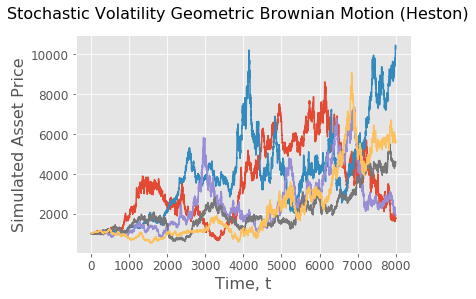

In [77]:
stochastic_volatility_examples = []
for i in range(paths):
    stochastic_volatility_examples.append(heston_model_levels(mp)[0])
plot_stochastic_processes(stochastic_volatility_examples, "Stochastic Volatility Geometric Brownian Motion (Heston)")

Now it is time to analyse the simulated data:

In [78]:
#First, we wrangle the data to the form expected by the initial example
assets_dframes = []
for i, asset in enumerate(stochastic_volatility_examples):  
    assets_dframes.append(pd.DataFrame(asset, columns= ["Adj Close"]))

In [84]:
# add logarithmic return data to pandas DataFrame data using the 'Adjusted Close' stock price for each day
def computeReturn(data, name, tau):
    data[name]=pd.Series(normalize(logreturn(data['Adj Close'].values, tau)),index=data.index[:-tau])
for stock in assets_dframes:
    computeReturn(stock,'Return d1',180)

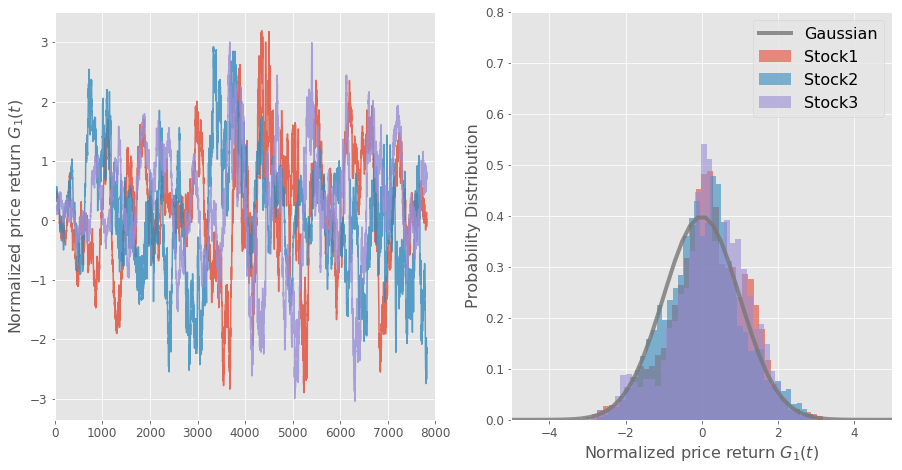

In [86]:
fig, [ax,bx] = plt.subplots(figsize=(15.0, 7.5),ncols=2)
for data,lbl in zip([assets_dframes[i] for i in random.sample(range(len(assets_dframes)), 3)],['Stock1','Stock2','Stock3']):
    data['Return d1'].plot(ax=ax,alpha=0.8)
    data['Return d1'].hist(ax=bx,alpha=0.6,normed=True,bins=40,lw=0,label=lbl)
x = np.linspace(-5,5)
bx.plot(x,np.exp(-x**2/2)/np.sqrt(2*np.pi),lw=4,alpha=0.8,label='Gaussian')
bx.legend()
ax.set_ylabel('Normalized price return $G_1(t)$')
bx.set_xlabel('Normalized price return $G_1(t)$')
bx.set_ylabel('Probability Distribution')
bx.set_xlim([-5,5])
bx.set_ylim([0,0.8])
plt.show()

We can see that the normalized daily returns are not really gaussian, although they are soemwhat closer to the normal distribution that the returns obtained from true stock data (see original notebook). Funnilly, by increasing the period ($\tau$) over which we compute the normalized price returns, we obtain a distribution that is skewed towards positive values. This is not unexpected an can be seen also in real data. It is however instructive to recall that the simplest way how to earn moeny on stock market is siimply to hold diversidfied protfolio of stocks.

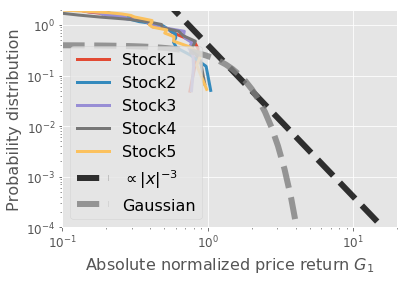

In [87]:
fig,ax=plt.subplots(subplot_kw={'xlabel':r'Absolute normalized price return $G_1$','ylabel':r'Probability distribution'})
# probability distribution for stocks
for stock,lbl in zip(assets_dframes, ['Stock1','Stock2','Stock3', 'Stock4', 'Stock5']):
    edges,hist=pdf_estimate(np.abs(stock['Return d1']),bins=30)
    ax.plot(edges,hist,label=lbl,lw=3)
# probability distribution for stock indices 
# power law x^-3
x = np.logspace(-1, 1.2)
ax.plot(x,0.4*x**(-3),lw=6,ls='--',color='k',alpha=0.8,label=r'$\propto |x|^{-3}$')
ax.plot(x,np.abs(np.exp(-x**2/2)/np.sqrt(2*np.pi)),lw=6,ls='--',color='gray',alpha=0.8,label=r'Gaussian')
ax.semilogy()
ax.semilogx()
ax.set_ylim(1e-4, 2e0)
ax.set_xlim(1e-1, 2e1)
ax.legend(loc=3, fontsize=16, framealpha=0.8)
plt.show()